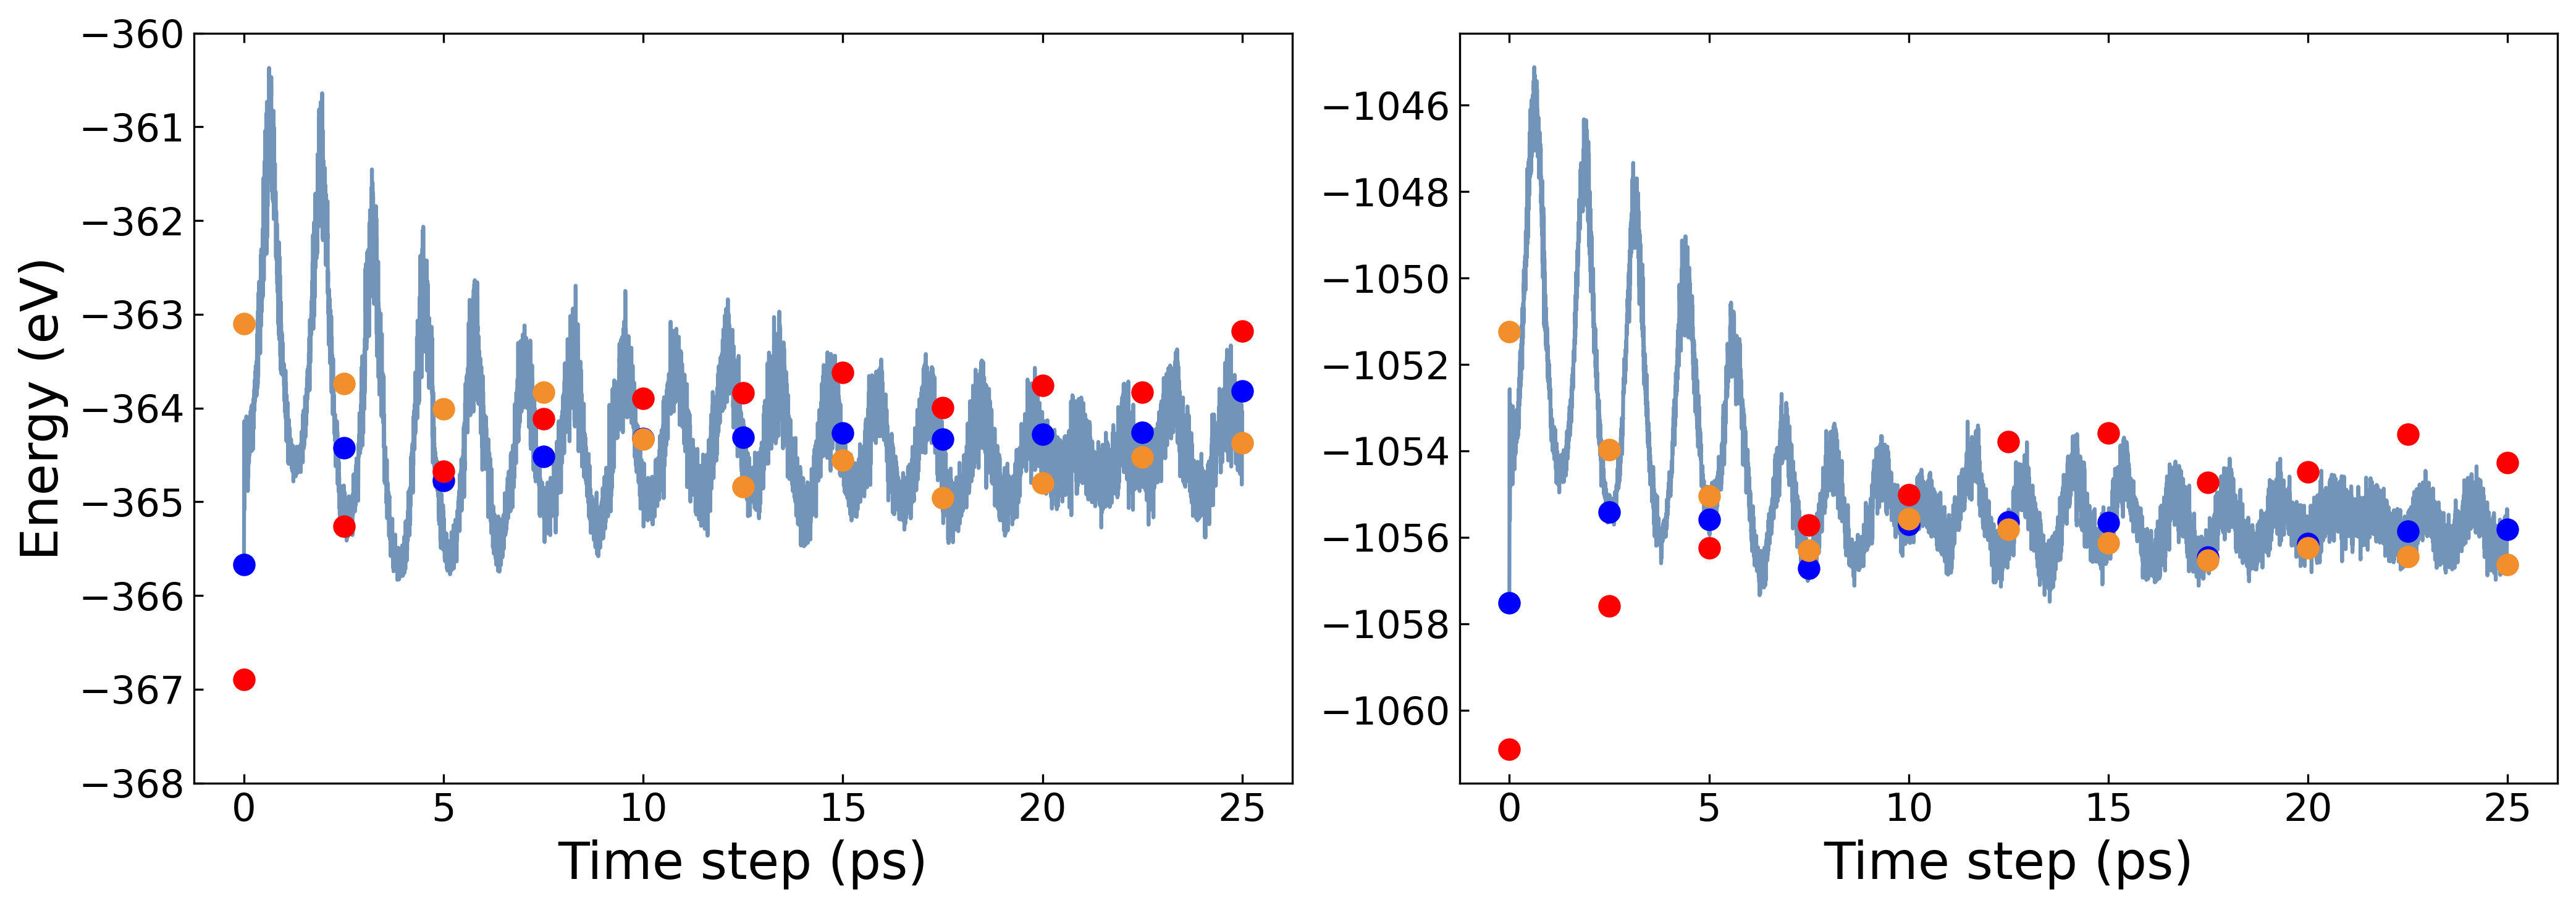

In [5]:
import datetime
import matplotlib.pyplot as plt
import numpy as np

def timestamp(string=None, fmt="%m/%d/%Y %H:%M:%S"):
    if string is not None:
        d = datetime.datetime.strptime(string, fmt)
    else:
        d = datetime.datetime.now()
    return d.timestamp()

def parse_logfile(file="active.log", window=(None, None)):
    start = None
    settings = []
    elapsed = []
    energies = []
    temperatures = []
    covloss = []
    exact_energies = []
    test_energies = []
    meta = []
    
    for line in open(file):
        if line.startswith("#"):
            continue

        s = line.split()
        ts = timestamp(" ".join(s[:2]))
        if start is None:
            start = ts
        ts = (ts - start) / 60
        split = s[2:]

        if split[1] == "settings:":
            settings = {}
            b = None
            for a in split[2:]:
                if ":" in a:
                    settings[a] = ""
                    b = a
                else:
                    settings[b] += a
            settings = {a: eval(b) for a, b in settings.items()}

        try:
            step = int(split[0])
            if window[0] and step < window[0]:
                continue
            if window[1] and step > window[1]:
                break
        except IndexError:
            continue

        elapsed += [(step, ts)]

        try:
            energies.append((step, float(split[1])))
            temperatures.append((step, float(split[2])))
            covloss.append((step, float(split[3])))
        except:
            pass

        if "meta:" in split:
            meta.append((step, float(split[split.index("meta:") + 1])))

        if "exact energy" in line:
            exact_energies.append((step, float(split[3])))

        if "testing energy" in line:
            test_energies.append((step, float(split[3])))

    return energies, exact_energies, test_energies

# 시간 위치 공유용 xenergy
xenergy = np.linspace(0, 25, 11)

# 첫 번째 로그 파일용 에너지
yenergy1 = [-363.100, -363.736, -364.010, -363.832, -364.334, -364.836, -364.559, -364.957, -364.800, -364.522, -364.371]
yenergy2 = [-366.89354, -365.26021, -364.67128, -364.11647, -363.89833, -363.83866, -363.62115, -363.99267, -363.76115, -363.83288, -363.17677]
yenergy3 = [-365.6690, -364.4237, -364.7709, -364.5175, -364.3225, -364.3134, -364.2691, -364.3331, -364.2821, -364.2604, -363.8182]

# 두 번째 로그 파일용 에너지
yenergy1_b = [-1051.2416, -1053.9681, -1055.0442, -1056.3024, -1055.5737, -1055.8215, -1056.1352, -1056.5313, -1056.2406, -1056.4399, -1056.6339]
yenergy2_b = [-1060.9016, -1057.5879, -1056.243, -1055.7136, -1055.011, -1053.7898, -1053.5908, -1054.7314, -1054.4803, -1053.6113, -1054.2722]
yenergy3_b = [-1057.5260, -1055.4116, -1055.5857, -1056.7143, -1055.7061, -1055.6410, -1055.6652, -1056.4555, -1056.1421, -1055.8607, -1055.8218]

def plot_combined(file1, file2, y1, y2, y3, y1_b, y2_b, y3_b):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5), dpi=300, sharey=False)

    for idx, (file, ax, y_DFT, y_SGPR, y_BCM) in enumerate([
        (file1, axs[0], y2, y1, y3),
        (file2, axs[1], y2_b, y1_b, y3_b)
    ]):
        ml, fp, test = parse_logfile(file)
        x_ml, y_ml = zip(*ml)
        scaling_factor = 25 / 100000
        x_ml_scaled = [x * scaling_factor for x in x_ml]

        ax.plot(x_ml_scaled, y_ml, zorder=1, color='#4e79a7', alpha=0.8)

        if fp:
            x_fp, y_fp = zip(*fp)
            ax.scatter(x_fp, y_fp, color="red", zorder=2, s=60)
    
        if test:
            x_test, y_test = zip(*test)
            ax.scatter(x_test, y_test, color="green", zorder=2, s=60)

        # Plot energy points
        ax.scatter(xenergy, y_BCM, color='blue', zorder=3, s=60)
        ax.scatter(xenergy, y_SGPR, color='#f28e2b', zorder=3, s=60)
        ax.scatter(xenergy, y_DFT, color='red',  zorder=3, s=60)

        ax.set_xlabel("Time step (ps)", fontsize=20)
        ax.tick_params(axis='both', labelsize=15, direction='in', top=True, bottom=True)
        # ax.xaxis.grid(True, linestyle='--', alpha=0.5)

        if idx == 0:
            ax.set_ylabel("Energy (eV)", fontsize=20)
            ax.set_ylim(-368, -360)  
        # ax.set_title(f"Case {idx+1}", fontsize=16)
        # ax.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig("Figure3.png", dpi=600)
    plt.show()

# 실행
plot_combined(
    '../Data/Fig.3/active.log',
    '../Data/Fig.3/bcm_active.log',
    yenergy1, yenergy2, yenergy3,
    yenergy1_b, yenergy2_b, yenergy3_b
)
